### 환경 설정

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import rcParams
sns.set()
%matplotlib inline
rcParams['font.family'] = 'Malgun Gothic'
rcParams['font.size'] = 20
rcParams['axes.unicode_minus'] = False 

In [3]:
import os
os.chdir("../../데이터")

### 데이터 준비

In [4]:
import pandas as pd
sp_data_dict = dict()
for file_name in os.listdir("주가데이터"):
    sp_data = pd.read_csv("주가데이터/" + file_name, parse_dates = ['Date'])
    stock_name = file_name.replace('.csv', '')
    sp_data_dict[stock_name] = sp_data

####  이동 평균 계산

In [5]:
for stock_name in sp_data_dict.keys():
    # 이동 평균 계산
    sp_data = sp_data_dict[stock_name]
    sp_data['MA_5'] = sp_data['Close'].rolling(5).mean()
    sp_data['MA_20'] = sp_data['Close'].rolling(20).mean()
    sp_data['MA_60'] = sp_data['Close'].rolling(60).mean()
    sp_data['MA_120'] = sp_data['Close'].rolling(120).mean()
    sp_data.dropna(inplace = True)

#### 골든 크로스, 데드 크로스 변수 추가

In [6]:
import itertools
import numpy as np

for stock_name in sp_data_dict.keys():
    sp_data = sp_data_dict[stock_name]
    for cross, st, lt in itertools.product(['G', 'D'], [5, 20], [60, 120]):
        output_col = "{}_{}_{}".format(cross, st, lt)
        st_col = "MA_" + str(st)
        lt_col = "MA_" + str(lt)
        st_data = sp_data[st_col].values
        lt_data = sp_data[lt_col].values
        if cross == "G":
            output = (st_data[1:] >= lt_data[1:]) & (st_data[:-1] < lt_data[:-1])
        elif cross == "D":
            output = (st_data[1:] < lt_data[1:]) & (st_data[:-1] >= lt_data[:-1])
        output = np.insert(output, 0, False)
        sp_data[output_col] = output   

#### 이동 평균선과 골든/데드 크로스 시각화: 삼성전자 예시

Text(0.5, 0, '날짜')

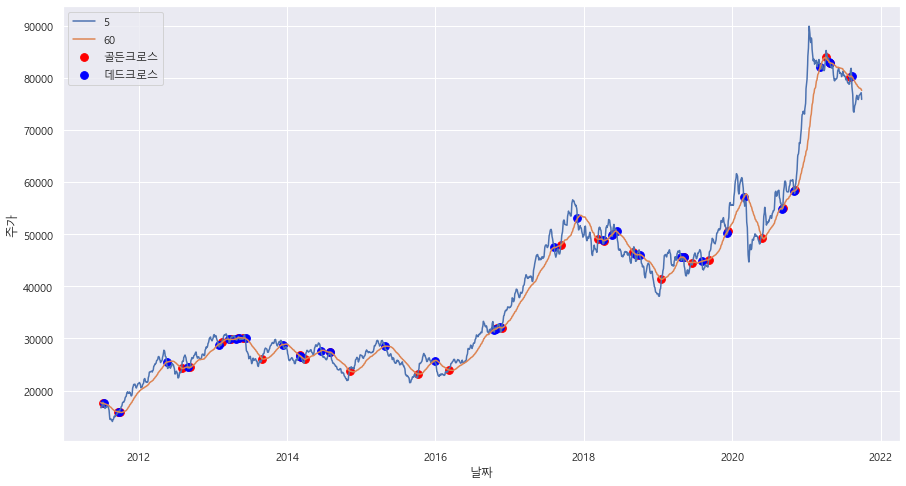

In [7]:
plt.figure(figsize = (15, 8))
samsung = sp_data_dict['삼성전자']
plt.plot(samsung['Date'], samsung['MA_5'], label = "5")
plt.plot(samsung['Date'], samsung['MA_60'], label = "60")

golden_cross_data = samsung.loc[samsung['G_5_60']]
dead_cross_data = samsung.loc[samsung['D_5_60']]

plt.scatter(golden_cross_data['Date'], golden_cross_data['MA_60'],
            label = "골든크로스", color = "red", s = 60)
plt.scatter(dead_cross_data['Date'], dead_cross_data['MA_60'],
            label = "데드크로스", color = "blue", s = 60)
plt.legend()
plt.ylabel("주가")
plt.xlabel("날짜")

### 골든/데드 크로스 발생시 매매하는 전략 검증

#### 매매 전략 구현

In [8]:
def calc_ror_using_gd_cross(sp_data_dict, stock_name, st, lt):
    money = 10 ** 8
    sp_data = sp_data_dict[stock_name]
    gc_idx_list = sp_data.loc[sp_data['G_{}_{}'.format(st, lt)]].index
    dc_idx_list = sp_data.loc[sp_data['D_{}_{}'.format(st, lt)]].index

    for buy_idx in gc_idx_list:
        if sum(dc_idx_list > buy_idx) == 0:
            sell_idx = sp_data.index.max()
        else:
            sell_idx = dc_idx_list[dc_idx_list > buy_idx].min()
        buy_price = sp_data.loc[buy_idx, 'Close']
        sell_price = sp_data.loc[sell_idx, 'Close']
        num_stocks = money / buy_price
        money = num_stocks * sell_price
    ror = (money - 10 ** 8) / 10 ** 8 * 100
    return round(ror, 3)

In [9]:
print(calc_ror_using_gd_cross(sp_data_dict, "삼성전자", 5, 60))

155.077


In [10]:
def calc_ror_using_buy_and_hold(sp_data_dict, stock_name):
    sp_data = sp_data_dict[stock_name]
    buy_price = sp_data["Close"].iloc[0]
    sell_price = sp_data["Close"].iloc[-1]
    ror = (sell_price - buy_price) / buy_price * 100
    return ror

In [11]:
print(calc_ror_using_buy_and_hold(sp_data_dict, "삼성전자"))

345.3125


In [12]:
print(samsung.loc[samsung['G_5_60'], 'Date'].iloc[0])
print(samsung.loc[samsung['D_5_60'], 'Date'].iloc[-1])
print(samsung['Date'].iloc[0])
print(samsung['Date'].iloc[-1])

2011-07-07 00:00:00
2021-08-12 00:00:00
2011-06-28 00:00:00
2021-09-30 00:00:00


#### 시장을 고려하지 않은 매매 전략 검증

In [13]:
result = []
for stock_name in sp_data_dict.keys():
    record = [stock_name]
    for st, lt in itertools.product([5, 20], [60, 120]):
        profit = calc_ror_using_gd_cross(sp_data_dict, stock_name, st, lt)
        record.append(profit)
    ror = calc_ror_using_buy_and_hold(sp_data_dict, stock_name)    
    record.append(ror)
    result.append(record)

result = pd.DataFrame(result,
         columns = ["종목명", "5-60", "5-120", "20-60", "20-120", "바이앤홀드"])

In [14]:
display(result.describe().round(2))

,5-60,5-120,20-60,20-120,바이앤홀드
count,2178.00,2178.00,2178.00,2178.00,2178.00
mean,63.34,45.30,54.71,48.95,138.30
std,230.87,191.47,209.03,183.23,322.50
min,-98.21,-96.65,-97.16,-97.07,-99.90
25%,-37.27,-40.66,-36.97,-39.20,-21.46
50%,4.06,-2.61,0.08,-0.45,42.25
75%,79.67,63.52,72.01,66.24,176.38
max,3944.32,3404.22,4030.00,2082.34,5036.36


In [15]:
result.set_index('종목명').idxmax(axis = 1).value_counts(normalize = True)

바이앤홀드     0.488522
5-60      0.155647
20-60     0.135445
20-120    0.121671
5-120     0.098714
dtype: float64

#### 시장을 고려한 매매 전략 검증

In [16]:
market_cap = pd.read_excel("211104_시가총액.xlsx")
market_cap = market_cap.loc[market_cap['종목명'].isin(result['종목명'])]
market_cap['그룹'] = pd.qcut(market_cap['시가총액'], 20, labels = range(1, 21))
market_cap['그룹'] = market_cap['그룹'].astype(int)
market_cap = market_cap[['종목명', '시장구분', '그룹']]
display(market_cap.head())

,종목명,시장구분,그룹
0,3S,KOSDAQ,11
1,AJ네트웍스,KOSPI,13
2,AK홀딩스,KOSPI,15
3,APS홀딩스,KOSDAQ,15
4,AP시스템,KOSDAQ,15


In [17]:
result = pd.merge(result, market_cap, on = "종목명")

In [18]:
cols = ['5-60', '5-120', '20-60', '20-120', '바이앤홀드']
display(result.groupby('시장구분')[cols].apply(np.mean))

,5-60,5-120,20-60,20-120,바이앤홀드
시장구분,,,,,
KOSDAQ,59.253663,39.668059,51.455146,46.605504,150.351769
KOSPI,70.750070,55.319248,60.358097,53.309891,116.582166


<AxesSubplot:xlabel='그룹'>

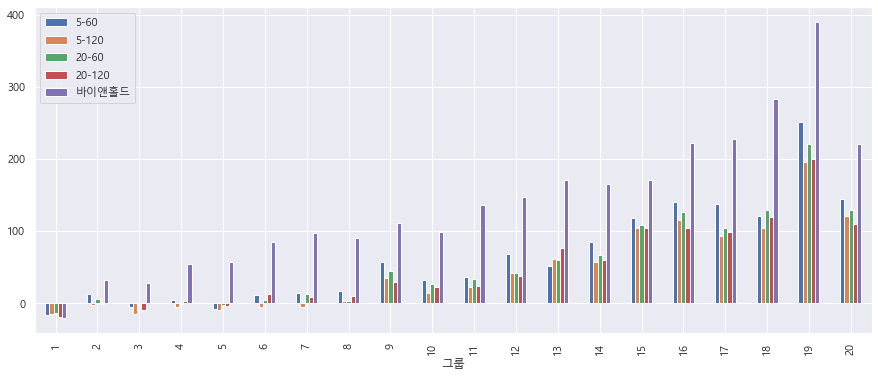

In [19]:
result.groupby('그룹')[cols].apply(np.mean).plot(kind = 'bar', figsize = (15, 6))

### 골든 크로스 지점에서 매수시의 효과 분석

#### 거래량 컬럼 추가

In [20]:
for stock_name in sp_data_dict.keys():
    stock_data = sp_data_dict[stock_name]
    stock_data['V5'] = stock_data['Volume'].rolling(5).mean()
    stock_data.dropna(inplace = True)
    V5_10 = np.quantile(stock_data['V5'], 0.9)
    V5_20 = np.quantile(stock_data['V5'], 0.8)
    stock_data['V5_10_group'] = stock_data['V5'] > V5_10
    stock_data['V5_20_group'] = stock_data['V5'] > V5_20

#### 전략 구현

In [21]:
def calc_ror(stock_data, buy_idx, num_day):
    sell_idx = buy_idx + num_day
    if sell_idx in stock_data.index:
        buy_price = stock_data['Close'].loc[buy_idx]
        sell_price = stock_data['Close'].loc[sell_idx]
        ror = (sell_price - buy_price) / buy_price * 100
        return ror
    else:
        return np.nan

In [26]:
S = pd.Series([1,2,3,4], index = ["A", "B", "C", "D"])

In [29]:
print((S % 2 == 0).index)

Index(['A', 'B', 'C', 'D'], dtype='object')


In [22]:
result_dict = dict()
for num_day in [60, 120, 240]:
    gc_result = []  # 골든 크로스
    v10_gc_result = []  # 거래량 상위 10% 골든 크로스
    v20_gc_result = []  # 거래량 상위 20% 골든 크로스
    random_result = []  # 임의

    for stock_name in sp_data_dict.keys():
        stock_data = sp_data_dict[stock_name]
        # 인덱스 정의
        gc_idx_list = stock_data.loc[stock_data["G_5_60"]].index
        v10_idx_list = stock_data.loc[stock_data["V5_10_group"]].index
        v10_gc_idx_list = v10_idx_list & gc_idx_list
        v20_idx_list = stock_data.loc[stock_data["V5_20_group"]].index
        v20_gc_idx_list = v20_idx_list & gc_idx_list
        ran_idx_candidate = stock_data.index[:-num_day]
        ran_idx_list = np.random.choice(
            ran_idx_candidate, min(len(ran_idx_candidate), 50), replace=False
        )

        for gc_idx in gc_idx_list:
            ror = calc_ror(stock_data, gc_idx, num_day)
            gc_result.append(ror)
        for v10_gc_idx in v10_gc_idx_list:
            ror = calc_ror(stock_data, v10_gc_idx, num_day)
            v10_gc_result.append(ror)
        for v20_gc_idx in v20_gc_idx_list:
            ror = calc_ror(stock_data, v20_gc_idx, num_day)
            v20_gc_result.append(ror)
        for random_idx in ran_idx_list:
            ror = calc_ror(stock_data, random_idx, num_day)
            random_result.append(ror)
    result_dict[num_day] = [gc_result, v10_gc_result, v20_gc_result, random_result]

#### 결과 확인

In [23]:
gc_result, v10_gc_result, v20_gc_result, random_result = result_dict[60]  # 60일
gc_result = pd.Series(gc_result).describe()
v10_gc_result = pd.Series(v10_gc_result).describe()
v20_gc_result = pd.Series(v20_gc_result).describe()
random_result = pd.Series(random_result).describe()
total_result = pd.concat(
    [gc_result, v10_gc_result, v20_gc_result, random_result], axis=1
)
total_result.columns = ["골든크로스", "10%_골든크로스", "20%_골든크로스", "임의"]
display(total_result)

,골든크로스,10%_골든크로스,20%_골든크로스,임의
count,69898.000000,8733.000000,17025.000000,108900.000000
mean,4.343206,0.897543,2.211130,4.596847
std,30.564906,33.496585,34.039434,30.284163
min,-89.246159,-86.853147,-86.853147,-93.387391
25%,-11.224467,-16.671765,-15.377358,-10.850596
50%,-0.333056,-4.318937,-3.275530,0.000000
75%,12.940281,10.468750,11.764706,13.076923
max,1053.284672,1053.284672,1053.284672,1451.724138


In [24]:
gc_result, v10_gc_result, v20_gc_result, random_result = result_dict[120]  # 120일
gc_result = pd.Series(gc_result).describe()
v10_gc_result = pd.Series(v10_gc_result).describe()
v20_gc_result = pd.Series(v20_gc_result).describe()
random_result = pd.Series(random_result).describe()
total_result = pd.concat(
    [gc_result, v10_gc_result, v20_gc_result, random_result], axis=1
)
total_result.columns = ["골든크로스", "10%_골든크로스", "20%_골든크로스", "임의"]
display(total_result)

,골든크로스,10%_골든크로스,20%_골든크로스,임의
count,68041.000000,8293.000000,16253.000000,108900.000000
mean,8.177602,2.660970,4.662696,9.443855
std,45.556751,45.757685,47.823677,47.493837
min,-93.387391,-88.623853,-88.623853,-93.387391
25%,-14.882943,-20.949510,-19.858156,-14.178126
50%,-0.576923,-5.660377,-4.377104,0.304878
75%,18.823529,14.617940,16.519174,20.000000
max,1203.964758,1114.240305,1114.240305,1502.497399


In [25]:
gc_result, v10_gc_result, v20_gc_result, random_result = result_dict[240]  # 240일
gc_result = pd.Series(gc_result).describe()
v10_gc_result = pd.Series(v10_gc_result).describe()
v20_gc_result = pd.Series(v20_gc_result).describe()
random_result = pd.Series(random_result).describe()
total_result = pd.concat(
    [gc_result, v10_gc_result, v20_gc_result, random_result], axis=1
)
total_result.columns = ["골든크로스", "10%_골든크로스", "20%_골든크로스", "임의"]
display(total_result)

,골든크로스,10%_골든크로스,20%_골든크로스,임의
count,64010.000000,7233.000000,14424.000000,108023.000000
mean,15.991894,6.038554,8.332117,18.490502
std,71.662686,61.702953,65.492561,75.313281
min,-95.166667,-95.084332,-95.084332,-95.857301
25%,-19.594435,-27.481618,-26.344071,-18.900549
50%,0.113194,-7.297297,-5.932647,1.783841
75%,30.215422,21.935484,24.146898,32.920165
max,2519.863014,1068.421053,1204.347826,2489.395808
